In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import langevin_cached_model as lcm
import pymc3 as pm
import scipy.io
import scipy as sp

In [11]:
# function to calculate A and B from the dataset
def OUanalytic(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    return Q/N,B

In [2]:
oxy_data37=scipy.io.loadmat('results/fMRI/OXY37_MRI_1_ts.mat')

mean:  -6.40646955775e-14
var:  43.9215908216
N:  736
1.00260386676


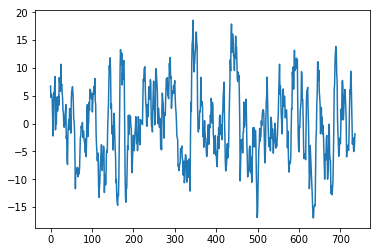

In [15]:
mpfc_r_ts=oxy_data37['mpfc_r_ts']
mpfc=np.mean(mpfc_r_ts,axis=0)
plt.plot(mpfc)
print("mean: ",mpfc.mean())
print("var: ",mpfc.std()**2)
N=len(mpfc)
print("N: ",N)
mpfc_A,mpfc_B = OUanalytic(mpfc)
mpfc_norm=mpfc/np.sqrt(mpfc_A)
print(mpfc_norm.std())

mean:  -8.15965652533e-14
var:  36.788213768
N:  736
1.00603547113


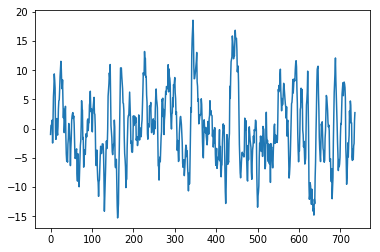

In [16]:
pcc_r_ts=oxy_data37['pcc_r_ts']
pcc=np.mean(pcc_r_ts,axis=0)
plt.plot(pcc)
print("mean: ",pcc.mean())
print("var: ",pcc.std()**2)
N=len(pcc)
print("N: ",N)
pcc_A,pcc_B = OUanalytic(pcc)
pcc_norm=pcc/np.sqrt(pcc_A)
print(pcc_norm.std())

mean:  -1.73831963317e-13
var:  13.3465095649
N:  736
1.00363933686


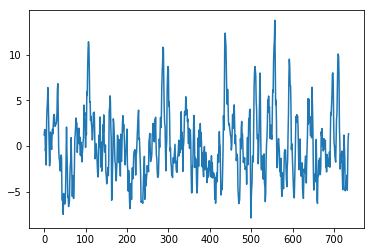

In [22]:
rlp_r_ts=oxy_data37['rlp_r_ts']
rlp=np.mean(rlp_r_ts,axis=0)
plt.plot(rlp)
print("mean: ",rlp.mean())
print("var: ",rlp.std()**2)
N=len(rlp)
print("N: ",N)
rlp_A,rlp_B = OUanalytic(rlp)
rlp_norm=rlp/np.sqrt(rlp_A)
print(rlp_norm.std())

mean:  -1.19749620847e-13
var:  73.2901308929
N:  736
1.00614250393


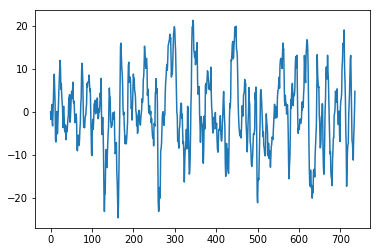

In [25]:
llp_r_ts=oxy_data37['llp_r_ts']
llp=np.mean(llp_r_ts,axis=0)
plt.plot(llp)
print("mean: ",llp.mean())
print("var: ",llp.std()**2)
N=len(llp)
print("N: ",N)
llp_A,llp_B = OUanalytic(llp)
llp_norm=llp/np.sqrt(llp_A)
print(llp_norm.std())

In [28]:
def OUcross(data1,data2):
    x1 = data1 + data2
    x2 = data1 - data2
    x1_A, x1_B = OUanalytic(x1)
    x2_A, x2_B = OUanalytic(x2)
    return (x1_A - x2_A)/x2_A
print(OUcross(mpfc_norm,pcc_norm))
print(OUcross(mpfc_norm,rlp_norm))
print(OUcross(mpfc_norm,llp_norm))
print(OUcross(pcc_norm,rlp_norm))
print(OUcross(pcc_norm,llp_norm))
print(OUcross(rlp_norm,llp_norm))

11.2736044314
0.885471845355
3.66581801856
1.14251791253
8.35049631085
1.32708145158


In [4]:
# initial prior
# both D and A have mean 1 and std 10
alpha_A=400.0/16.0
beta_A=1.0/16.0
alpha_N=400.0/16.0
beta_N=1.0/16.0
alpha_D=2.0+1.0/1.6
beta_D=100*(alpha_D-1)
delta_t=0.802

In [5]:
with pm.Model() as model:
    D = pm.InverseGamma('D', alpha=alpha_D, beta=beta_D)
    A = pm.Gamma('A', alpha=alpha_A, beta=beta_A)
    sN = pm.InverseGamma('sN', alpha=alpha_N, beta=beta_N)

    B = pm.Deterministic('B', pm.exp(-delta_t * D / A))

    path = lcm.Ornstein_Uhlenbeck('path',D=D, A=A, B=B, shape=mpfc.shape)

    X_obs = pm.Normal('X_obs', mu=path, sd=sN, observed=mpfc)
    
    start = pm.find_MAP(fmin=sp.optimize.fmin_powell)
    
    trace = pm.sample(10000,start=start)

Applied log-transform to D and added transformed D_log to model.
Applied log-transform to A and added transformed A_log to model.
Applied log-transform to sN and added transformed sN_log to model.
Assigned NUTS to D_log
Assigned NUTS to A_log
Assigned NUTS to sN_log
Assigned NUTS to path
 [-----------------100%-----------------] 10000 of 10000 complete in 690.6 sec

In [6]:
trace

<MultiTrace: 1 chains, 10000 iterations, 8 variables>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1204feba8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1242c40f0>]], dtype=object)

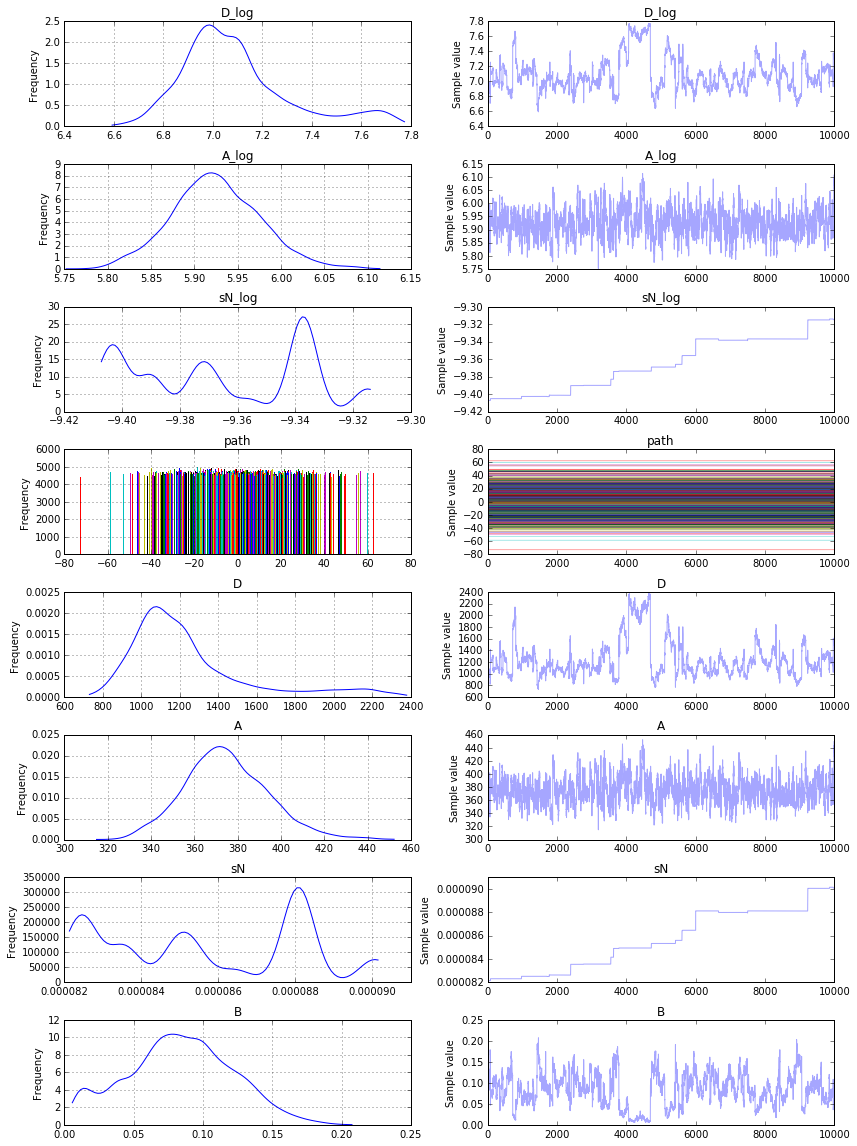

In [7]:
pm.traceplot(trace)

In [8]:
pm.summary(trace)


D_log:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  7.092            0.227            0.021            [6.749, 7.672]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  6.756          6.944          7.047          7.181          7.683


A_log:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  5.925            0.051            0.003            [5.818, 6.021]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  5.825          5.891          5.923          5.958          6.030


sN_log:

  Mean             SD               MC Error         95% HPD interval
  ------------------------

/Users/hstrey/anaconda/envs/python3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  7.887            0.000            0.000            [7.887, 7.887]
  14.829           0.000            0.000            [14.829, 14.829]
  -16.043          0.000            0.000            [-16.044, -16.043]
  -11.458          0.000            0.000            [-11.458, -11.458]
  -0.503           0.000            0.000            [-0.503, -0.503]
  42.902           0.000            0.000            [42.902, 42.903]
  -15.251          0.000            0.000            [-15.251, -15.251]
  -14.297          0.000            0.000            [-14.297, -14.297]
  29.793           0.000            0.000            [29.793, 29.793]
  -18.794          0.000            0.000            [-18.794, -18.794]
  9.919            0.000            0.000            [9.919, 9.920]
  20.582           0.000            0.000            [20.582, 20.583]
  0.524    